# Advantage Actor-Critic (A2C)


https://arxiv.org/pdf/1506.02438.pdf

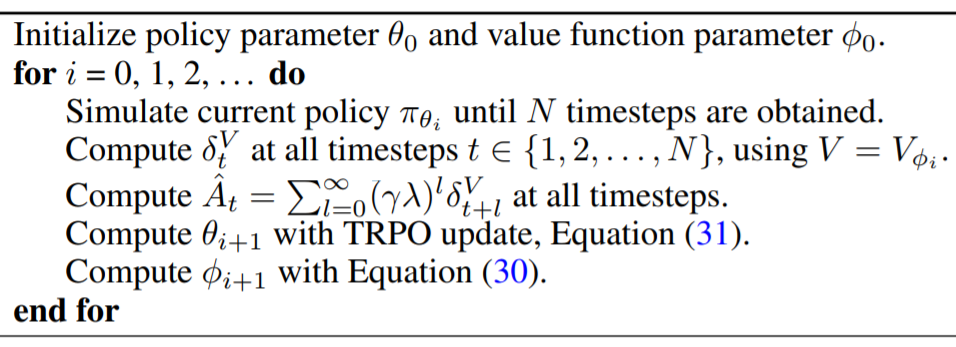

There is no TRPO update here, just advantage and MSE

In [1]:
import numpy as np
import gym
import tensorflow as tf
import scipy
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from SpiderEnv.SpiderEnv import SpiderEnv

critic_learning_rate = 1e-4
actor_learning_rate = 1e-4
epochs_number = 3000000
batch_size = 128
replay_buffer_size = batch_size
l2_regularization = 0

discount_factor = 0.98
lambda_factor = 0.96

angle_normalization = 135

env_name = 'SpiderEnv'
environments_count = 20

# This code gets action and observation space sizes for 1D tasks
env = SpiderEnv()
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]


In [2]:
observation_space

20

## Create environments vector

In [3]:
def make_env(env_id, seed):
    def _f():
        env = SpiderEnv()
        env.reset()
        for i in range(int(200*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

## Define model architecture

In [4]:
epsilon = 1e-8

def gaussian_loglikelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [5]:
tf.reset_default_graph()

class ActorNetworkContinuous:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        mu = tf.layers.dense(l3, units=action_space)

        log_std = tf.get_variable(name='log_std', initializer=-0.5 * np.ones(action_space, dtype=np.float32))
        std = tf.exp(log_std)

        self.action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std


        # Training
        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)

        action_logprob = gaussian_loglikelihood(self.action_ph, mu, log_std)

        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = -tf.reduce_mean(action_logprob * self.weight_ph) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=actor_learning_rate).minimize(self.loss)


class ActorNetworkDiscrete:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])
        l1 = tf.layers.dense(self.state_ph, units=20, activation=tf.nn.relu)
        output_linear = tf.layers.dense(l1, units=action_space)

        output = tf.nn.softmax(output_linear)
        self.action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), axis=1)
        #action_op = tf.expand_dims(tf.constant(1), axis=0)

        # Training
        output_log = tf.nn.log_softmax(output_linear)

        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None], dtype=tf.int32)

        action_one_hot = tf.one_hot(self.action_ph, action_space)
        responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
        self.loss = -tf.reduce_mean(responsible_output_log * self.weight_ph)

        optimizer = tf.train.AdamOptimizer(learning_rate=actor_learning_rate)
        self.update_op = optimizer.minimize(self.loss)

    
class CriticNetwork:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)        
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        output = tf.layers.dense(l3, units=1)
        
        self.value_op = tf.squeeze(output, axis=-1)
        print(self.value_op)

        # Training
        self.value_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        
        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = tf.losses.mean_squared_error(self.value_ph, self.value_op) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=critic_learning_rate).minimize(self.loss)
    
actor = ActorNetworkContinuous()
critic = CriticNetwork()

W0722 16:36:35.044471 12012 deprecation.py:323] From <ipython-input-5-f1ca94053e9b>:7: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0722 16:36:35.049143 12012 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 16:36:35.547029 12012 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("Squeeze:0", shape=(?,), dtype=float32)


In [6]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [7]:
a = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
np.hstack((a, [[11], [12], [13]]))

array([[ 1,  2,  3, 11],
       [ 4,  5,  6, 12],
       [ 7,  8,  9, 13]])

In [8]:
def f(x):
    x[0] = 6

In [9]:
a = np.array([1, 2, 3])
f(a)
print(a)

[6 2 3]


In [10]:
def discount_cumsum(x, coef):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-coef)], x[::-1], axis=0)[::-1]

discount_cumsum([1, 2, 4, 8], 0.5)

array([4., 6., 8., 8.])

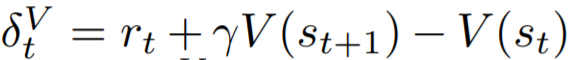

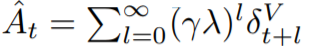

In [11]:
def estimate_advantage(states, rewards):
    values = sess.run(critic.value_op, feed_dict={critic.state_ph: states})
    deltas = rewards - values
    deltas = deltas + discount_factor * np.append(values[1:], np.array([0]))
    
    advantage = discount_cumsum(deltas, coef=lambda_factor * discount_factor)
    
#     gamma_labda_powers = [(discount_factor * lambda_factor) ** l for l in range(len(states))]
#     advantage2 = np.zeros_like(rewards)
#     for t in range(len(values)):
#         for l in range(len(states) - t): # We have finite sum case
#             advantage2[t] += gamma_labda_powers[l] * deltas[t + l]
    return advantage, values

In [12]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    
    # [state, action, advantage, discounted reward-to-go]
    replay_buffer = np.empty((0,4), np.float32)
    
    # [state, action, reward] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': [], 'max_action': [], 'mean_advantage': [], 'mean_value': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions = sess.run(actor.action_op, feed_dict={actor.state_ph: observations})
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions * angle_normalization)
            observations /= angle_normalization
            
            history['max_action'].append(np.abs(actions).max())
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            # Process done==True environments
            if dones.all():
                print('WARNING: envs are in sync!!')

            done_indexes = np.arange(envs_number)[dones]
            for i in done_indexes:
                rewards_trajectory = rollouts[i][:, 2].copy()
                history['reward'].append(rewards_trajectory.sum())
                
                # Perform generalized advantage estimation
                advantage, values = estimate_advantage(states=np.array(rollouts[i][:, 0].tolist()),
                                                       rewards=rewards_trajectory)
                history['mean_value'].append(values.mean())
                history['mean_advantage'].append(advantage.mean())

                rollouts[i][:, 2] = advantage

                discounted_reward_to_go = discount_cumsum(rewards_trajectory, coef=discount_factor)

                
                rollout = np.hstack((rollouts[i], np.expand_dims(discounted_reward_to_go, axis=-1)))                
                replay_buffer = np.append(replay_buffer, rollout, axis=0)
                rollouts[i] = np.empty((0, 3))
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([ 0.66666667, -0.40942109,  0.58083191,  0.05592505, -0.28661202,
       -0.66666667, -0.28689084, -0.15120187, -0.41195744, -0.66666667,
       -0.51678066, -0.66666667,  0.        , -0.42059191, -0.28370681,
        0.        , -0.66666667,  0.        ,  0.00740741,  0.        ]),
        array([-0.5249903 ,  0.447739  ,  0.5213686 , -0.00625496,  0.51149154,
        0.35512745,  0.02668104, -0.341721  , -0.35421932,  0.10659722,
       -0.2138862 ,  0.42917803,  0.13637884,  0.11601453,  1.0550584 ,
       -0.4049807 ,  0.19164824,  1.0306332 ], dtype=float32),
        -78.78646675874761, -225.97539524799882],
       [array([ 0.66666667,  0.66666667,  0.66666667,  0.10119019,  0.47854654,
        0.01091275,  0.        , -0.53607409, -0.59667257, -0.28727779,
       -0.36130727, -0.66666667, -0.02607897,  0.        ,  0.        ,
        0.        , -0.32395347,  0.        ,  0.00740741,  0.        ]),
        array([ 1.4921591 , -0.17609729, -0.17676339, -0.1779739 , 

## Train agent 

In [12]:
history = {'reward': [], 'actor_loss': [], 'critic_loss': [], 
           'max_action': [], 'mean_value': [], 'mean_advantage': []}

In [13]:
max_value = 6069

In [ ]:
from tqdm import tqdm_notebook
import pickle

batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)

# Makes them of equal lenght
print('Charging generators')
for i in range(20):
    next(batch_generator)

saver = tf.train.Saver()

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    history['max_action'] += batch_history['max_action']
    history['mean_advantage'] += batch_history['mean_advantage']
    history['mean_value'] += batch_history['mean_value']


    value = int(np.mean(history["reward"][-10:]))
    if max_value < value:
        save_path = saver.save(sess, f'./models/{env_name}-A2C-reward({value}).ckpt')
        print("Model saved in path: %s" % save_path)
        max_value = value
        
        with open(f'models/{env_name}-A2C-reward({value}).history', 'wb') as f:
            pickle.dump(history, f)
            
    _, actor_loss = sess.run([actor.update_op, actor.loss], feed_dict={
                                                actor.state_ph: np.array(batch[:, 0].tolist()),
                                                actor.action_ph: np.array(batch[:, 1].tolist()),
                                                actor.weight_ph: batch[:, 2]})

    _, critic_loss = sess.run([critic.update_op, critic.loss], feed_dict={
                                                critic.state_ph: np.array(batch[:, 0].tolist()),
                                                critic.value_ph: batch[:, 3]})
    
#     history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
#     history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))    
    history['critic_loss'].append(critic_loss)
    history['actor_loss'].append(actor_loss)



Charging generators


Learning rate - очень чувствительный 1e-3 - не учится (взрывается до +беск), 1e-4 не сходится, 3e-4 ОК



Похоже, что policy gradient должен иметь как можно более быстрый отклик от среды, иначе мы штрафуем его за действия из другого распределения

Кажется, теперь понятно зачем нужны trust region'ы - без них что-то происходит и policy умирает


## Plot results

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

Text(0.5, 0.98, 'SpiderEnv')

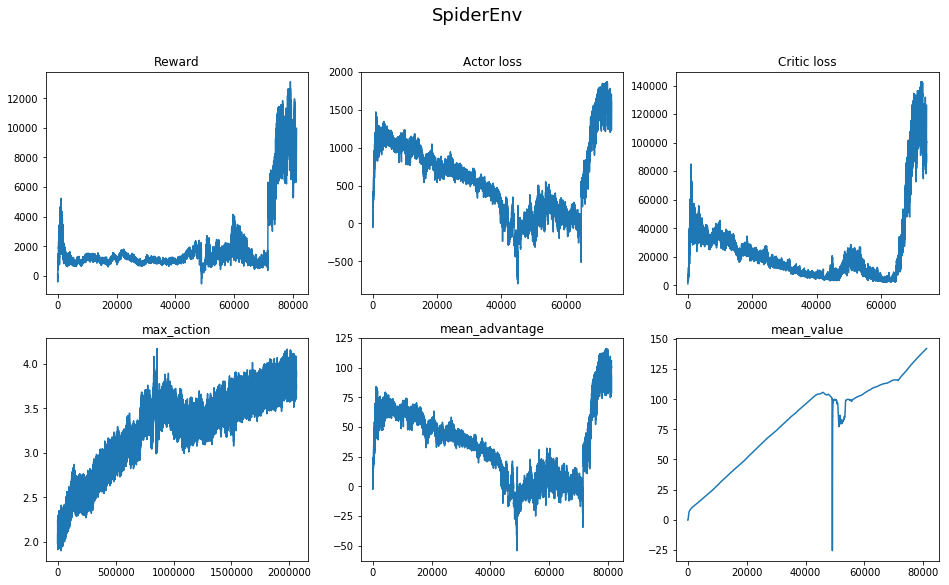

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['actor_loss'], 'Actor loss', axs[0, 1])
plot(history['critic_loss'], 'Critic loss', axs[0, 2])

# plot(history['gradients_max_abs'], 'Gradients max (not from adam)', axs[1, 0])


# parameters_number = np.sum([np.ones_like(g).sum() for g in gradients_])
# plot(history['gradients_equal_zero'], f'Gradients equal zero out of {int(parameters_number)} parameters', axs[1, 1])

plot(history['max_action'], 'max_action', axs[1, 0])
plot(history['mean_advantage'], 'mean_advantage', axs[1, 1])
plot(history['mean_value'], 'mean_value', axs[1, 2])

plt.suptitle(env_name, fontsize=18)

# plt.savefig(f'logs/{env_name}')

## Our agent

In [22]:
observations = env.reset()

for i in range(10000):
    env.render()
    actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations]})

    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0] * angle_normalization)
    observations = observations.astype(np.float32) / angle_normalization

    if dones:
        observations = env.reset()
        print('Done')

Creating window glfw
Done
Done
Done
Done
Done
Done
Done
Done
Done


## Random agent

In [ ]:
observations = env.reset()
rewards_sum = 0


for i in range(10000000):
    env.render()
    actions = [[np.random.randint(2) - 1 for i in range(action_space)] for i in range(1000)]
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[i])
    print(rewards)
    rewards_sum += rewards
    
    if dones:
        observations = env.reset()
        print('Done', rewards_sum)
        rewards_sum = 0

In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

In [ ]:
import pickle
with open('logs/history.file', 'wb') as f:
    pickle.dump(history, f)

In [15]:
# import pickle
# with open('models/SpiderEnv-A2C-reward(6069).history', 'rb') as f:
#     history = pickle.load(f)

In [14]:
# saver = tf.train.Saver()
# saver.restore(sess, "./models/SpiderEnv-A2C-reward(6069).ckpt")

W0722 16:37:34.448831 12012 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

import pickle
with open('logs/history.file', 'wb') as f:
    pickle.dump(history, f)

# import pickle
# with open('logs/history.file', 'rb') as f:
#     history = pickle.load(f)

# saver = tf.train.Saver()
# saver.restore(sess, "./models/SpiderEnv-A2C-reward(10802).ckpt")

# Real Robot


In [ ]:
# from multiprocessing import Process
# from gym_spider import *
# from ServotorAPI import *


# servo_dict = {14: 5, 8: 6, 2: 7,
#                13: 9, 7: 10, 1: 11,
#                18: 13, 12: 14, 6: 15,
#                17: 18, 11: 17, 5: 16,
#                16: 22, 10: 21, 4: 20,
#                15: 26, 9: 25, 3: 24}

# s = ServotorAPI(degree_type="std")
# s.center_servos()

# observations = env.reset()
# minuses = np.array([2 * (i > 6 and i < 12) - 1 for i in range(18)])

# for i in range(10000):
#     actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations]})
# #     actions = np.array([np.array([np.random.randint(-90, 90) for i in range(18)]) * minuses]) / angle_normalization

#     actions = np.array([np.array([-(i > 6) * 45 for i in range(18)]) * minuses]) / angle_normalization
#     for servo in range(1, 19):
#         s.move_servo(servo_dict[servo], actions[0][servo - 1] * angle_normalization)
    
#     observations = actions[0]
#     observations = np.append(observations, [1, 0])
    

In [29]:
from SpiderEnv.SpiderEnv import SpiderEnv
from ServotorAPI import *

spider_env = SpiderEnv()
s = ServotorAPI(degree_type="std")


for i in range(100000):
    spider_env.render()    
    action = [-(i > 5) * 45 for i in range(18)]
    
    o, r, d, _ = spider_env.step(action)
    spider_env.step_robot(s)

s.kill_all_servos()
s.close_connection()

Exception: arduino doesn`t connected

In [ ]:
s.kill_all_servos()
s.close_connection()

In [ ]:




for i in range(100):
    n = np.sin(i / 5) * 90
